In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
% cd /content/drive/MyDrive/Colab_Notebooks/Netology/NLP

/content/drive/MyDrive/Colab_Notebooks/Netology/NLP


In [2]:
import json
import bz2
import regex
from tqdm import tqdm
from scipy import sparse

In [3]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)
        # if len(responses) >= 40000:
        #     break

201030it [02:55, 1145.68it/s]


In [5]:
df = pd.json_normalize(responses)[['bank_name', 'city', 'rating_grade', 'text', 'title']]
df.head()

,bank_name,city,rating_grade,text,title
0,Бинбанк,г. Москва,NaN,Добрый день! Я не являюсь клиентом банка и пор...,Жалоба
1,Сбербанк России,г. Новосибирск,NaN,Доброго дня! Являюсь держателем зарплатной кар...,Не могу пользоваться услугой Сбербанк он-лайн
2,Бинбанк,г. Москва,NaN,Здравствуйте! Дублирую свое заявление от 03.0...,Двойное списание за один товар.
3,Сбербанк России,г. Ставрополь,NaN,Добрый день!! Я открыл расчетный счет в СберБа...,Меняют проценты комиссии не предупредив и не ...
4,ОТП Банк,г. Челябинск,NaN,"04.03.2015 г. взяла кредит в вашем банке, заяв...",Верните денежные средства за страховку


## Часть 1. Анализ текстов

### 1. Количество отзывов по городам и банкам

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153499 entries, 0 to 153498
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   bank_name     153499 non-null  object 
 1   city          138325 non-null  object 
 2   rating_grade  88658 non-null   float64
 3   text          153499 non-null  object 
 4   title         153499 non-null  object 
dtypes: float64(1), object(4)
memory usage: 5.9+ MB


In [ ]:
cities_NA = round(100 - 138325 / 153499 * 100)
rating_grade = round(100 - 88658 / 153499 * 100)
print(f'В {cities_NA}% случаев нет информации о городе')
print(f'В {rating_grade}% случаев нет информации об оценке')

В 10% случаев нет информации о городе
В 42% случаев нет информации об оценке


Таким образом, при группировке данных по городу, мы потеряем 10% данных. Из сгруппированных данных выберем колонку title, т.к. она не содержит пропусков.

In [ ]:
t1 = df.groupby(['city', 'bank_name'])['title'].count().reset_index()
t1.columns = ['Город', 'Банк', 'Количество отзывов']
t1.sort_values(by=['Количество отзывов'], ascending=False)

,Город,Банк,Количество отзывов
7453,г. Москва,Сбербанк России,8146
7160,г. Москва,Альфа-Банк,3871
7437,г. Москва,Русский Стандарт,2801
7206,г. Москва,ВТБ 24,2714
12394,г. Санкт-Петербург,Сбербанк России,2434
...,...,...,...
7733,"г. Москва, Отделение ""Жулебинское""",Московский Кредитный Банк,1
7734,"г. Москва, ""Китай-город""",Фора-Банк,1
7735,"г. Москва, Ветошный пер",Восточный Экспресс Банк,1
7736,"г. Москва, Видное",Сбербанк России,1


Судя по содержанию столбца city (Город), мы получаем группировку данных не только по городам, но и по отдельных районам/улицам. Для получения более достоверных результатов можно было бы использовать базу городов для приведения данных к единому формату. Но в этом случае мы бы опять потеряли часть данных.

### 2. Гистограммы:

2.1. Длин слов (в символах) \
[За слово считаем последовательность букв русского алфавита]

In [ ]:
import re
from collections import Counter

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
ru_words = re.compile("[А-Яа-я]+")


def count_words_length(text):
    return Counter(map(len, ru_words.findall(text)))


def count_centence_length(text):
    centences = nltk.tokenize.sent_tokenize(text)
    centences_len = [len(cent.split()) for cent in centences]
    return Counter(centences_len)

In [ ]:
from functools import reduce

res = reduce(lambda x, y: x + y, map(count_words_length, df.text))

График

<BarContainer object of 42 artists>

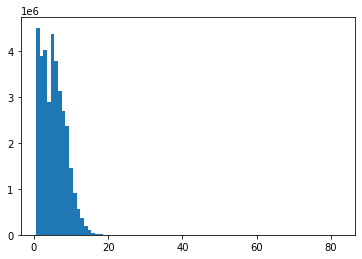

In [ ]:
plt.bar(res.keys(), res.values(), width=1, align='center')

Гистограмма

In [ ]:
mylist = [key for key, val in res.items() for _ in range(val)]

(array([1.2432466e+07, 1.1062646e+07, 8.2325880e+06, 2.3647560e+06,
        1.1459760e+06, 1.7108800e+05, 1.4707000e+04, 3.5090000e+03,
        1.5680000e+03, 4.4000000e+01, 1.0000000e+01, 2.0000000e+00,
        4.0000000e+00, 0.0000000e+00, 2.0000000e+00, 0.0000000e+00,
        1.0000000e+00, 0.0000000e+00, 1.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 1.0000000e+00, 0.0000000e+00,
        1.0000000e+00, 0.0000000e+00, 1.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 2.0000000e+00]),
 array([ 1. ,  3.7,  6.4,  9.1, 11.8, 14.5, 17.2, 19.9, 22.6, 25.3, 28. ,
        30.7, 33.4, 36.1, 38.8, 41.5, 44.2, 46.9, 49.6, 52.3, 55. , 57.7,
        60.4, 63.1, 65.8, 68.5, 71.2, 73.9, 76.6, 79.3, 82. ]),
 <a list of 30 Patch objects>)

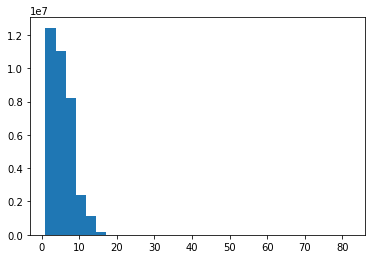

In [ ]:
plt.hist(mylist, bins=30)

2.1. Длин предложений (в словах)\
[За слово считаем любую последовательность символов, выделяемую методом split без параметров]

In [ ]:
res2 = reduce(lambda x, y: x + y, map(count_centence_length, df.text))

График

<BarContainer object of 236 artists>

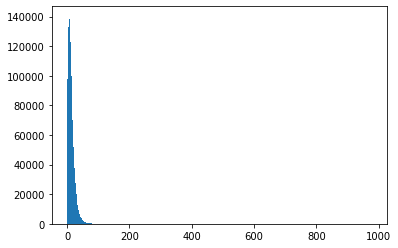

In [ ]:
plt.bar(res2.keys(), res2.values(), width=1, align='center')

Гистограмма

In [ ]:
mylist2 = [key for key, val in res2.items() for _ in range(val)]

(array([1.250314e+06, 8.933140e+05, 3.374540e+05, 1.072040e+05,
        4.462000e+04, 1.707300e+04, 7.204000e+03, 3.066000e+03,
        1.788000e+03, 9.340000e+02, 5.600000e+02, 2.720000e+02,
        2.070000e+02, 1.430000e+02, 8.400000e+01, 5.500000e+01,
        4.200000e+01, 2.000000e+01, 2.300000e+01, 2.100000e+01,
        1.400000e+01, 6.000000e+00, 8.000000e+00, 7.000000e+00,
        4.000000e+00, 4.000000e+00, 2.000000e+00, 0.000000e+00,
        4.000000e+00, 2.000000e+00, 1.000000e+00, 0.000000e+00,
        1.000000e+00, 0.000000e+00, 1.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 1.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.00

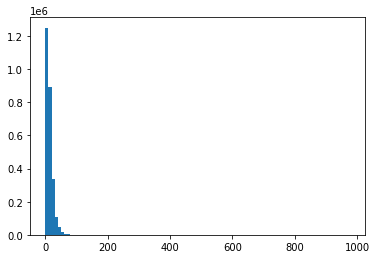

In [ ]:
plt.hist(mylist2, bins=100)

### 3. 10 самых частых:

In [6]:
import re
from nltk.corpus import stopwords

In [7]:
from tqdm.auto import tqdm
tqdm.pandas()

In [8]:
! pip install pymorphy2
import pymorphy2

m = pymorphy2.MorphAnalyzer()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
mystopwords = stopwords.words('russian') + [
    'это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д',
    'который','прошлый','сей', 'свой', 'наш', 'мочь', 'такой'
]

ru_words = re.compile("[А-Яа-я]+")


def words_only(text):
    return " ".join(ru_words.findall(text.lower()))


def lemmatize(text):
    try:
        return  " ".join([m.parse(w)[0].normal_form for w in text.lower().split()])
    except:
        return " "


def remove_stopwords(text, mystopwords = mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""

def preprocess(text):
    return remove_stopwords(lemmatize(words_only(text.lower())))

3.1. Слов

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
tmp = df.text.astype('str').progress_apply(words_only)

  0%|          | 0/153499 [00:00<?, ?it/s]

In [ ]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(tmp)

In [ ]:
words_stats = list(zip(vectorizer.get_feature_names(), X.sum(0).getA1()))
print(*sorted(words_stats, key=lambda x: -x[1])[:10], sep='\n')

[('не', 4760), ('на', 3846), ('что', 3369), ('по', 2166), ('мне', 1706), ('банка', 1650), ('банк', 1394), ('но', 1091), ('как', 1051), ('за', 1035)]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


3.2. Слов без стоп-слов

In [ ]:
tmp = tmp.progress_apply(remove_stopwords)

  0%|          | 0/153499 [00:00<?, ?it/s]

In [ ]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(tmp)

In [ ]:
words_stats = list(zip(vectorizer.get_feature_names(), X.sum(0).getA1()))
print(*sorted(words_stats, key=lambda x: -x[1])[:10], sep='\n')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


('банка', 275906)
('банк', 215426)
('деньги', 131201)
('карту', 105829)
('карты', 101821)
('кредит', 81136)
('день', 76552)
('банке', 72169)
('заявление', 70423)
('очень', 66824)


3.3. Лемм

Лемматизатор pymorphy крайне медленный, поэтому обработаем только выборку из 10.000 отзывов.

In [ ]:
tmp = df.text.astype('str')[:10000].progress_apply(preprocess)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(tmp)

In [ ]:
words_stats = list(zip(vectorizer.get_feature_names(), X.sum(0).getA1()))
print(*sorted(words_stats, key=lambda x: -x[1])[:10], sep='\n')

('банк', 41820)
('карта', 18950)
('день', 10048)
('кредит', 9776)
('деньга', 9579)
('сотрудник', 9373)
('всё', 8796)
('клиент', 7981)
('сумма', 6997)
('счёт', 6974)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


3.4. Существительных

In [ ]:
def nouns(text):
    try:
        return  " ".join([m.parse(w)[0].word for w in text.lower().split() if 'NOUN' in m.parse(w)[0].tag])
    except:
        return " "

In [ ]:
tmp2 = tmp.progress_apply(nouns)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
vectorizer = CountVectorizer()
XN = vectorizer.fit_transform(tmp2)

In [ ]:
nouns_stats = list(zip(vectorizer.get_feature_names(), XN.sum(0).getA1()))
print(*sorted(nouns_stats, key=lambda x: -x[1])[:10], sep='\n')

('банк', 41820)
('карта', 18950)
('день', 10048)
('кредит', 9776)
('деньга', 9579)
('сотрудник', 9373)
('клиент', 7981)
('сумма', 6997)
('счёт', 6974)
('отделение', 6909)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### 4. Кривые Ципфа и Хипса

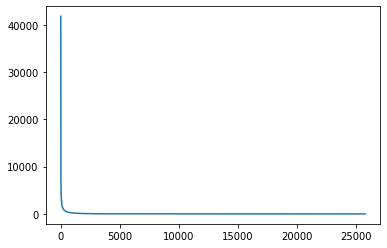

In [ ]:
plt.plot([freq for _, freq in sorted(words_stats, key=lambda x: -x[1])])
plt.show()

### 5. Частоты слов (на основе выборки из 10000 отзывов, т.к. для этого необходима лемматизация)

In [ ]:
find_words = ['сотрудник', 'клиент', 'мошенничество', 'доверие']

stats = {k: v for k, v in filter(lambda x: x[0] in find_words, nouns_stats)}

result = 'чаще' if stats['сотрудник'] > stats['клиент'] else 'реже'
print(f'Слово "сотрудник" встречается {result} слова "клиент"')
print(f'Частота слова "мошенничество": {stats["мошенничество"]}')
print(f'Частота слова "доверие": {stats["доверие"]}')

Слово "сотрудник" встречается чаще слова "клиент"
Частота слова "мошенничество": 221
Частота слова "доверие": 152


### 6. Ключевые слова и биграммы

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [38]:
pos_grades = df[(df['rating_grade'] == 5) & (df['text'].notna())][:10000]
neg_grades = df[(df['rating_grade'] == 1) & (df['text'].notna())][:10000]
len(pos_grades), len(neg_grades)

(10000, 10000)

In [18]:
pos_grades.text = pos_grades.text.astype('str').progress_apply(preprocess)

  0%|          | 0/10000 [00:00<?, ?it/s]

6.1. Для положительных отзывов

In [19]:
vectorizer = TfidfVectorizer()
pos_vectors = vectorizer.fit_transform(pos_grades.text)

In [24]:
vect_score = np.asarray(pos_vectors.mean(axis=0)).ravel().tolist()
vect_array = pd.DataFrame({'term': vectorizer.get_feature_names(), 'weight': vect_score})
vect_array.sort_values(by='weight',ascending=False,inplace=True)

print(vect_array.iloc[:20,:])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


                term    weight
14836           банк  0.045304
206168         карта  0.026237
79562            всё  0.019147
55690          вклад  0.018908
232723        кредит  0.016610
380105         очень  0.015854
359750     отделение  0.015453
581422     сотрудник  0.014557
215941        клиент  0.014266
119481          день  0.013759
121587        деньга  0.013535
374459          офис  0.013330
68570         вопрос  0.012108
99642            год  0.012041
47289           весь  0.011372
613010          счёт  0.011272
73792          время  0.011166
503996        работа  0.010823
325679  обслуживание  0.010223
585207       спасибо  0.009891


In [25]:
vectorizer = TfidfVectorizer(ngram_range=(2, 2))
pos_vectors = vectorizer.fit_transform(pos_grades.text)

In [26]:
vect_score = np.asarray(pos_vectors.mean(axis=0)).ravel().tolist()
vect_array = pd.DataFrame({'term': vectorizer.get_feature_names(), 'weight': vect_score})
vect_array.sort_values(by='weight',ascending=False,inplace=True)

print(vect_array.iloc[:20,:])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


                          term    weight
185267           интернет банк  0.007095
555834          сотрудник банк  0.006183
224942         кредитный карта  0.005577
206311             клиент банк  0.005226
343052          отделение банк  0.004086
657326         являться клиент  0.003866
123232             добрый день  0.003584
538073          следующий день  0.003542
76043               всё вопрос  0.003471
8646                альфа банк  0.003428
350044           открыть вклад  0.003287
636865         хотеть выразить  0.003250
108184         дебетовый карта  0.003210
210948              колл центр  0.002986
87390   выразить благодарность  0.002835
353418        отношение клиент  0.002774
357294               офис банк  0.002769
362835            очень быстро  0.002759
113944       денежный средство  0.002750
362980         очень довольный  0.002749


6.2. Для отрицательных отзывов

In [41]:
neg_grades.text = neg_grades.text.astype('str').progress_apply(preprocess)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [42]:
vectorizer = TfidfVectorizer()
neg_vectors = vectorizer.fit_transform(neg_grades.text)

In [44]:
vect_score = np.asarray(neg_vectors.mean(axis=0)).ravel().tolist()
vect_array = pd.DataFrame({'term': vectorizer.get_feature_names(), 'weight': vect_score})
vect_array.sort_values(by='weight',ascending=False,inplace=True)

print(vect_array.iloc[:20,:])

            term    weight
893         банк  0.080274
7809       карта  0.060411
4518      деньга  0.039001
8823      кредит  0.033592
4517        день  0.032472
14234  отделение  0.032193
22016  сотрудник  0.031274
22828       счёт  0.028866
2346       вклад  0.028560
6660   заявление  0.027500
21202    сказать  0.025669
3052         всё  0.025533
8080      клиент  0.025243
22703      сумма  0.025218
20680   сбербанк  0.021997
4879     договор  0.021578
14685       офис  0.021191
15755     платёж  0.020993
3911         год  0.020868
12757      номер  0.020821


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [45]:
vectorizer = TfidfVectorizer(ngram_range=(2, 2))
neg_vectors = vectorizer.fit_transform(neg_grades.text)

In [46]:
vect_score = np.asarray(neg_vectors.mean(axis=0)).ravel().tolist()
vect_array = pd.DataFrame({'term': vectorizer.get_feature_names(), 'weight': vect_score})
vect_array.sort_values(by='weight',ascending=False,inplace=True)

print(vect_array.iloc[:20,:])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


                       term    weight
522909       сотрудник банк  0.007808
101660    денежный средство  0.007241
86392         горячий линия  0.006408
320164       отделение банк  0.006184
209339      кредитный карта  0.006022
248561   написать заявление  0.005280
31371              ваш банк  0.004834
174355        интернет банк  0.004579
109962          добрый день  0.004292
197612           колл центр  0.004220
6552             альфа банк  0.003990
452853         рабочий день  0.003983
193176          клиент банк  0.003829
121409  досрочный погашение  0.003765
504977     служба поддержка  0.003724
276296        номер телефон  0.003380
96131       дебетовый карта  0.003309
209330    кредитный история  0.003159
502714       следующий день  0.003069
209287    кредитный договор  0.003011


## Часть 2. Тематическое моделирование (на основе выборки из 10000)

### 1. Тематические модели

In [13]:
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim import similarities

In [20]:
text_sample = df[df['text'].notna()].sample(10000, random_state=42)

In [21]:
text_sample.text = text_sample.text.astype('str').progress_apply(preprocess)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [25]:
texts = [text.split() for text in text_sample.text]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [26]:
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [27]:
index = similarities.MatrixSimilarity(corpus_tfidf)
sims = index[corpus_tfidf]

In [28]:
from gensim.models import lsimodel

Модель с количеством тем = 10

In [38]:
%%time
lsi = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=10)

CPU times: user 11.7 s, sys: 1.26 s, total: 13 s
Wall time: 17.8 s


In [39]:
lsi.show_topics()

[(0,
  '0.198*"карта" + 0.130*"кредит" + 0.117*"деньга" + 0.112*"заявление" + 0.107*"счёт" + 0.106*"банкомат" + 0.104*"отделение" + 0.101*"вклад" + 0.096*"сбербанк" + 0.096*"сумма"'),
 (1,
  '0.358*"кредит" + -0.304*"вклад" + -0.266*"банкомат" + -0.192*"карта" + 0.188*"страховка" + 0.141*"погашение" + 0.140*"платёж" + 0.139*"задолженность" + -0.128*"деньга" + 0.120*"договор"'),
 (2,
  '0.549*"вклад" + -0.263*"банкомат" + -0.183*"карта" + -0.171*"сбербанк" + -0.139*"заявление" + 0.127*"очередь" + 0.119*"открыть" + 0.117*"договор" + -0.106*"средство" + 0.105*"ставка"'),
 (3,
  '0.218*"сумма" + -0.213*"номер" + 0.209*"вклад" + 0.190*"банкомат" + 0.177*"руб" + -0.167*"заявка" + 0.164*"погашение" + 0.160*"платёж" + -0.151*"звонок" + 0.148*"досрочный"'),
 (4,
  '-0.336*"вклад" + -0.272*"номер" + 0.226*"карта" + 0.219*"страховка" + 0.205*"заявка" + -0.190*"звонок" + -0.151*"телефон" + -0.132*"ваш" + 0.129*"лимит" + 0.125*"кредит"'),
 (5,
  '-0.468*"банкомат" + 0.359*"карта" + 0.156*"лимит" + 

**Тема №9:**\
1) **Содержание:** '0.358*"страховка" + -0.271*"заявка" + 0.214*"карта" + -0.193*"документ" + 0.187*"сбербанк" + -0.143*"справка" + -0.142*"рассмотрение" + 0.127*"заявление" + 0.121*"страхование" + -0.120*"средство"'\
2) **Интерпретация:** судя по ключевым словам данной темы, речь идет об оформлении страховки: подаче заявки, документов, справки и т.д.

Модель с количеством тем = 40

In [40]:
%%time
lsi = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=40)

CPU times: user 9.88 s, sys: 873 ms, total: 10.8 s
Wall time: 8.97 s


In [42]:
lsi.show_topics()

[(0,
  '0.198*"карта" + 0.130*"кредит" + 0.117*"деньга" + 0.112*"заявление" + 0.107*"счёт" + 0.106*"банкомат" + 0.104*"отделение" + 0.101*"вклад" + 0.096*"сбербанк" + 0.096*"сумма"'),
 (1,
  '0.358*"кредит" + -0.304*"вклад" + -0.266*"банкомат" + -0.193*"карта" + 0.189*"страховка" + 0.140*"погашение" + 0.139*"платёж" + 0.139*"задолженность" + -0.129*"деньга" + 0.120*"договор"'),
 (2,
  '-0.549*"вклад" + 0.263*"банкомат" + 0.182*"карта" + 0.171*"сбербанк" + 0.139*"заявление" + -0.127*"очередь" + -0.119*"открыть" + -0.116*"договор" + -0.106*"ставка" + 0.105*"средство"'),
 (3,
  '0.217*"сумма" + -0.213*"номер" + 0.210*"вклад" + 0.189*"банкомат" + 0.178*"руб" + -0.169*"заявка" + 0.164*"погашение" + 0.158*"платёж" + -0.151*"звонок" + 0.147*"досрочный"'),
 (4,
  '-0.337*"вклад" + -0.271*"номер" + 0.223*"карта" + 0.218*"страховка" + 0.209*"заявка" + -0.186*"звонок" + -0.150*"телефон" + -0.133*"ваш" + 0.125*"кредит" + 0.124*"лимит"'),
 (5,
  '-0.468*"банкомат" + 0.361*"карта" + 0.158*"лимит" + 

**Тема №21:**\
1) **Содержание:** '0.490*"руб" + -0.308*"курс" + -0.273*"рубль" + -0.215*"евро" + -0.190*"доллар" + -0.171*"валюта" + 0.132*"комиссия" + -0.115*"касса" + 0.103*"документ" + 0.102*"смс"'\
2) **Интерпретация:** речь идет о вопросах, связанных с обменом валюты: обменная касса, курс валюты, коммиссия за обмен, необходимые документы.

### 2. Темы с упоминанием банков

In [54]:
def topics_with_banks(topics, banks):
    result = set()
    banks = [bank.lower() for bank in banks]
    topic_words = [ru_words.findall(text) for _, text in topics]
    for i, words in enumerate(topic_words):
        for w in words:
            if len(w) > 3 and w != 'кредит':
                for b in banks:
                    if w == b.split()[0]:
                        print(i, w, b)
                        result.add((b, i))

In [56]:
topics_with_banks(lsi.show_topics(), df.bank_name.unique())

0 сбербанк сбербанк россии
2 сбербанк сбербанк россии
6 сбербанк сбербанк россии
7 сбербанк сбербанк россии
8 сбербанк сбербанк россии
9 сбербанк сбербанк россии
11 сбербанк сбербанк россии
12 сбербанк сбербанк россии
12 киви киви банк
13 сбербанк сбербанк россии
13 киви киви банк
19 киви киви банк
22 сбербанк сбербанк россии
25 сбербанк сбербанк россии


**Тема №0:**\
1) **Содержание:** '0.198*"карта" + 0.130*"кредит" + 0.117*"деньга" + 0.112*"заявление" + 0.107*"счёт" + 0.106*"банкомат" + 0.104*"отделение" + 0.101*"вклад" + 0.096*"сбербанк" + 0.096*"сумма"'\
2) **Интерпретация:** вероятно, данная тема связана с вопросами об услугах, которые предоставляет Сбербанк: заведение карты, получение кредита, открытие вклада. Также вопросы могут касаться работы банкоматов и отделений данного банка.

**Тема №13:**\
1) **Содержание:** 0.242*"кошелёк" + -0.195*"претензия" + -0.193*"альфа" + -0.160*"платёж" + 0.159*"справка" + -0.156*"смс" + 0.155*"деньга" + -0.150*"услуга" + 0.149*"сбербанк" + 0.135*"киви"'\
2) **Интерпретация:** в данной теме упомянуто сразу 3 банка и слово "кошелёк", которое, вероятно, относится к банку Киви. Скорее всего, эта тема группирует отзывы, связанные с взаимодействием банков Сбербанк и Альфа-Банк с банком Киви.

## Часть 3. Классификация текстов

### 1. Составим обучающее и тестовое множества

Определим количество положительных и отрицательных отзывов

In [ ]:
len(df[df['rating_grade'] == 1]), len(df[df['rating_grade'] == 5])

(47387, 14713)

In [ ]:
N1 = round(len(df[df['rating_grade'] == 1]) * 0.3)
N2 = round(len(df[df['rating_grade'] == 5]) * 0.9)
N1, N2, N1 + N2

(14216, 13242, 27458)

In [ ]:
neg_texts = df[df['rating_grade'] == 1][['text', 'rating_grade']].sample(N1, random_state=42)
pos_texts = df[df['rating_grade'] == 5][['text', 'rating_grade']].sample(N2, random_state=42)
all_texts = pd.concat([neg_texts, pos_texts])

In [ ]:
all_texts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27458 entries, 69869 to 87110
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   text          27458 non-null  object 
 1   rating_grade  27458 non-null  float64
dtypes: float64(1), object(1)
memory usage: 643.5+ KB


Векторизуем тексты

In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score

In [ ]:
vectors = TfidfVectorizer().fit_transform(all_texts.text)

Разбиваем на обучающее и тестовое множества

In [ ]:
y_train, y_val, x_train, x_val = train_test_split(
    all_texts.rating_grade, vectors, test_size=0.2,
    random_state=42)

### 2. Обучаем классификатор

In [ ]:
clf = LogisticRegression()
clf.fit(x_train, y_train)

LogisticRegression()

In [ ]:
y_pred = clf.predict(x_val)

print('F1 score:\t', f1_score(y_val, y_pred))
print('Accuracy score:\t', accuracy_score(y_val, y_pred))

F1 score:	 0.9550600343053174
Accuracy score:	 0.9522942461762564


Попробуем другие варианты векторизации:

In [ ]:
def test_n_gram(x, y, model=LogisticRegression, params=[(1, 1)]):
    results = dict()
    for param in params:
        vectors = TfidfVectorizer(ngram_range=param).fit_transform(x)

        y_train, y_val, x_train, x_val = train_test_split(
            y, vectors, test_size=0.2,
            random_state=42)
        
        clf = model()
        clf.fit(x_train, y_train)

        y_pred = clf.predict(x_val)
        f1 = f1_score(y_val, y_pred)
        accuracy = accuracy_score(y_val, y_pred)
        results[param] = f1
        
        print(f'===== {param} =====',
              f'F1 score:\t {f1}',
              f'Accuracy score:\t {accuracy}', sep='\n')
    
    return results

а) n-граммы

In [ ]:
params = [(2, 2), (3, 3), (1, 2), (1, 3)]

n_gram_res = test_n_gram(all_texts.text, all_texts.rating_grade, params=params)

===== (2, 2) =====
F1 score:	 0.9369524136746263
Accuracy score:	 0.9331755280407866
===== (3, 3) =====
F1 score:	 0.8979859177992469
Accuracy score:	 0.8865622723962127
===== (1, 2) =====
F1 score:	 0.9526098901098901
Accuracy score:	 0.9497450837581938
===== (1, 3) =====
F1 score:	 0.9472236548048821
Accuracy score:	 0.9441005098324836


In [ ]:
print('Лучший результат:', max(n_gram_res.items(), key=lambda x: x[1]))

Лучший результат: ((1, 2), 0.9526098901098901)


б) символьные n-граммы

In [ ]:
vectors = TfidfVectorizer(min_df=0.01, max_df=0.95, analyzer='char_wb', ngram_range=(4, 8)).fit_transform(all_texts.text)

y_train, y_val, x_train, x_val = train_test_split(
    all_texts.rating_grade, vectors, test_size=0.2,
    random_state=42)

In [ ]:
clf = LogisticRegression()
clf.fit(x_train, y_train)

LogisticRegression()

In [ ]:
y_pred = clf.predict(x_val)

print('F1 score:\t', f1_score(y_val, y_pred))
print('Accuracy score:\t', accuracy_score(y_val, y_pred))

F1 score:	 0.9572210814510609
Accuracy score:	 0.9544792425345958


**Вывод**: лучший результат был получен при использовании символьных n-грамм (в рамках слов).

### 3. Использование скрытых тем

In [ ]:
y_train, y_val, x_train, x_val = train_test_split(
    all_texts.rating_grade, all_texts.text, test_size=0.2,
    random_state=42)

clf = Pipeline([ 
    ('vect', CountVectorizer(min_df=0.01, max_df=0.95, analyzer='char_wb', ngram_range=(4, 8))), 
    ('tfidf', TfidfTransformer()), 
    ('tm', TruncatedSVD(n_components=200)), 
    ('clf', LogisticRegression())
])

clf.fit(x_train, y_train)

Pipeline(steps=[('vect',
                 CountVectorizer(analyzer='char_wb', max_df=0.95, min_df=0.01,
                                 ngram_range=(4, 8))),
                ('tfidf', TfidfTransformer()),
                ('tm', TruncatedSVD(n_components=200)),
                ('clf', LogisticRegression())])

In [ ]:
y_pred = clf.predict(x_val)

print('F1 score:\t', f1_score(y_val, y_pred))
print('Accuracy score:\t', accuracy_score(y_val, y_pred))

F1 score:	 0.9491873396065011
Accuracy score:	 0.9459213401310997


**Вывод**: качество решения при использовании SVD ухудшилось. Возможно, помогло бы увеличение числа компонент, но ограничененная мощность Google Colabs не позволяет это выяснить.